# Sweep peaks and enrichments

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
from collections import Counter, defaultdict
import random, bisect

random.seed(7)

import pyfaidx

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

Import variables global to the entire analysis:

In [6]:
import analysis_globals

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1, x
    return x[0]

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')

## Distribution of number of swept individuals across the chromosome

In [9]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')
missing_regions = pandas.read_hdf(results_dir / 'missing_regions.hdf')

Bar plot for each region:

In [10]:
# group by start, end, region and compute size
plot_df = (sweep_data.loc[sweep_data.not_missing]
           .groupby(['start', 'end', 'region_1', 'region_label_1'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index(level=['start', 'end', 'region_1', 'region_label_1'])
          )
plot_df.head()

,start,end,region_1,region_label_1,nr_swept,total
0,2700000,2800000,Africa,Africa,0.0,21
1,2700000,2800000,WestEurasia,WestEurasia,0.0,47
2,2700000,2800000,SouthAsia,SouthAsia,0.0,31
3,2700000,2800000,CentralAsiaSiberia,CentralAsiaSiberia,0.0,10
4,2700000,2800000,Oceania,Oceania,0.0,16


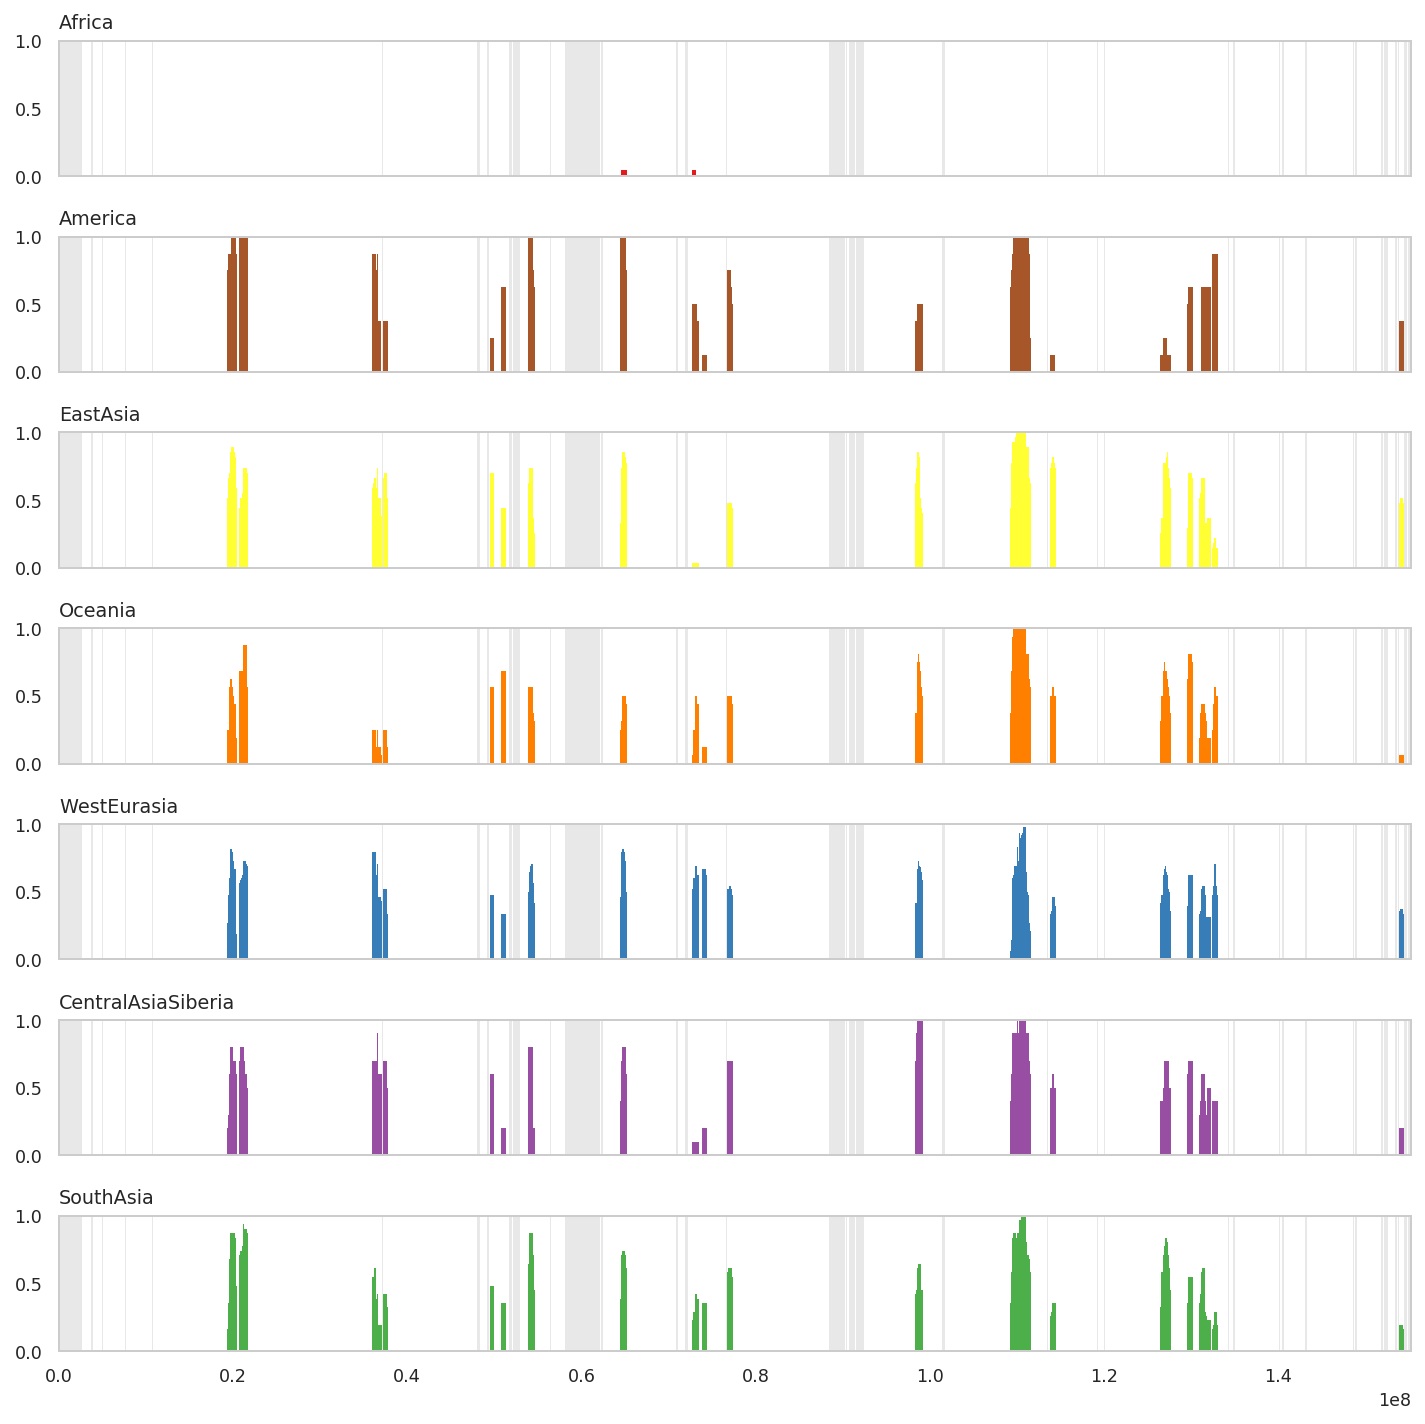

In [11]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(7, 1, sharex=True, sharey=True, figsize=(10, 10),                         
                             subplot_kw={'xlim':(0, chromosome_lengths['X']),
                                         'ylim':(0, 1)})

    for ax, reg in zip(axes, regions):
        df = plot_df.loc[plot_df.region_label_1 == reg]    
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.nr_swept/tup.total, 
                                 facecolor=region_colors[reg], 
                                 linewidth=0,
                                 #edgecolor=None,#region_colors[reg], 
                                 zorder=2))
        ax.set_title(reg, loc='left')
                
        for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                     facecolor='lightgray', 
                     linewidth=0,
#                     edgecolor=None,
                     alpha=0.5,
                     zorder=1))
    #     ax.set_ylim(0, df.nr_swept.max())

    plt.tight_layout()
    
    plt.savefig(str(figures_dir / "tot_swept_by_region.pdf"))
    #plt.close() # closing teh plot suppres automatic plotting without plt.show()


## Stacked bar plot for windows called as sweeps

In [12]:
plot_df.sort_values(by=['start', 'region_1'], inplace=True)

plot_df['cum_nr_swept'] = (plot_df
                           .loc[plot_df.region_label_1 != 'Africa']
                           .groupby(['start', 'end'])['nr_swept']
                           .transform('cumsum')    
                           )
plot_df['cum_total'] = (plot_df
                        .loc[plot_df.region_label_1 != 'Africa']
                        .groupby(['start', 'end'])['total']
                        .transform('sum')    
                        )
plot_df.head(7)

,start,end,region_1,region_label_1,nr_swept,total,cum_nr_swept,cum_total
0,2700000,2800000,Africa,Africa,0.0,21,NaN,NaN
1,2700000,2800000,WestEurasia,WestEurasia,0.0,47,0.0,139.0
2,2700000,2800000,SouthAsia,SouthAsia,0.0,31,0.0,139.0
3,2700000,2800000,CentralAsiaSiberia,CentralAsiaSiberia,0.0,10,0.0,139.0
4,2700000,2800000,Oceania,Oceania,0.0,16,0.0,139.0
5,2700000,2800000,EastAsia,EastAsia,0.0,27,0.0,139.0
6,2700000,2800000,America,America,0.0,8,0.0,139.0


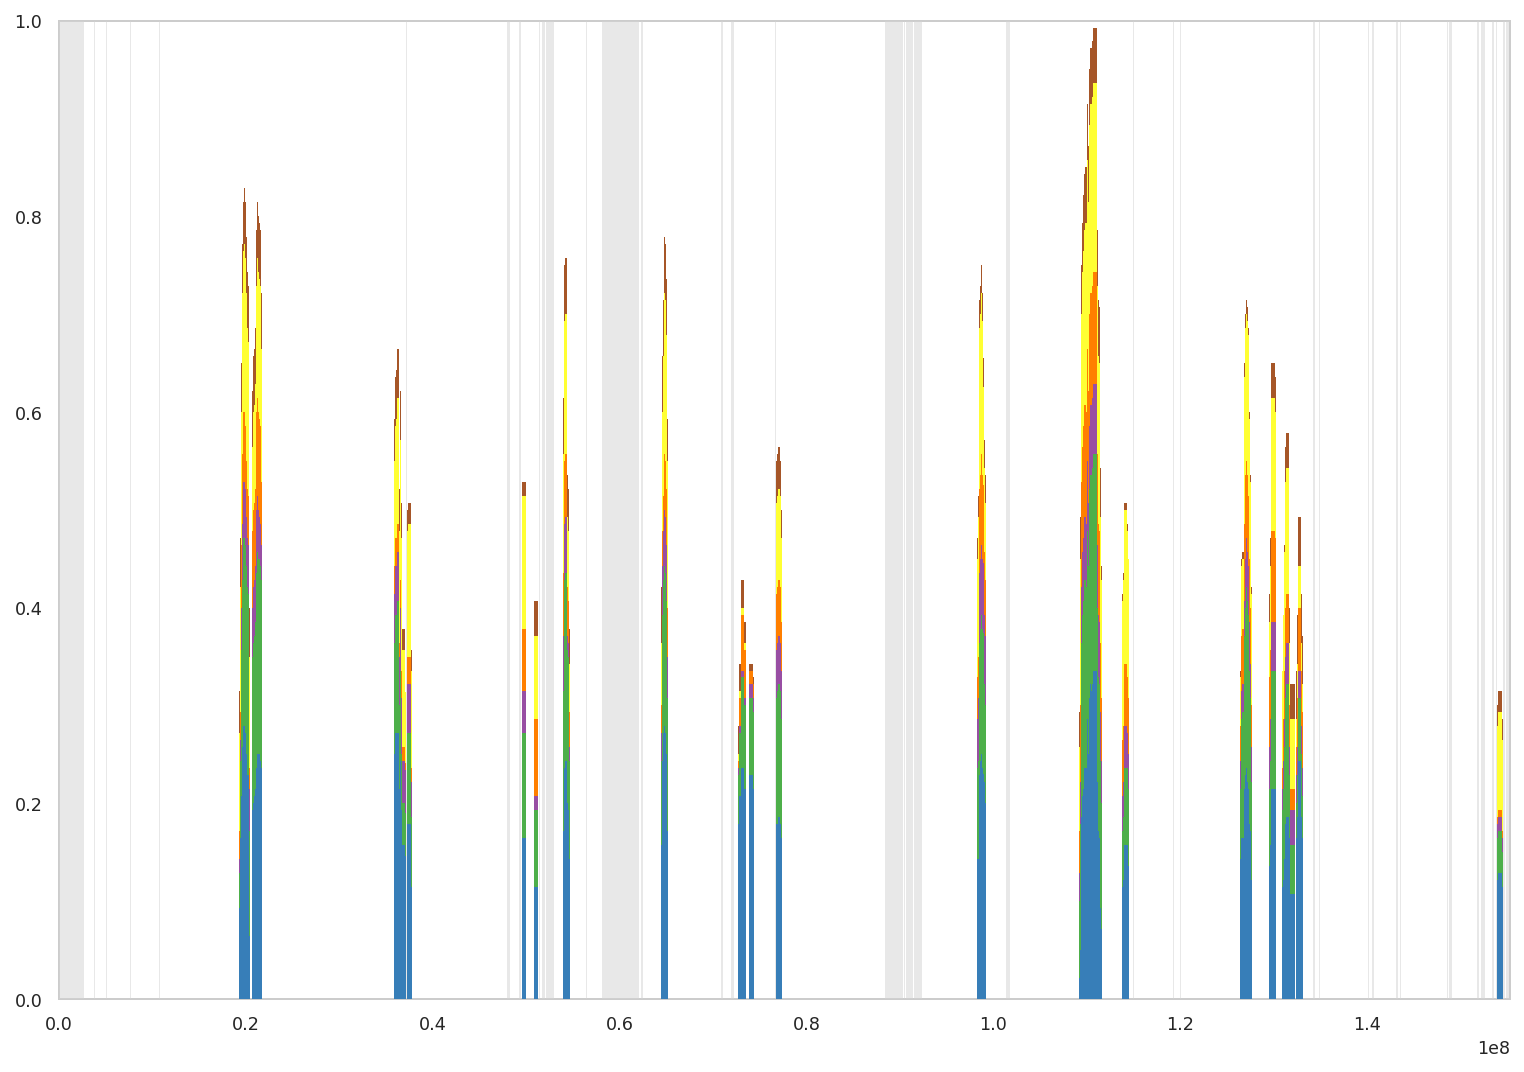

In [13]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(13, 9),                         
                                   subplot_kw={'xlim':(0, chromosome_lengths['X']), 'ylim':(0, 1)})

    zorder = 1
    regs = [x for x in plot_df.region_1.cat.categories if x != 'Africa'][::-1]
    for reg in regs:
        df = plot_df.loc[plot_df.region_label_1 == reg]
        zorder += 1        
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.cum_nr_swept/tup.cum_total, 
                                  facecolor=region_colors[reg], 
                                  linewidth=0,
                                  edgecolor=None,#region_colors[reg], 
                                  zorder=zorder))

    zorder += 1        
    for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
        g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                 facecolor='lightgray', 
                 linewidth=0,
                 alpha=0.5,
                 zorder=zorder))

#mpld3.display(fig)

## Finding the sweep centers

Pile up swept windows to find sweep centers. This should work even if sweeps are form standing variation (soft sweep) with multiple haplotypes sweeping.

Make a data set with total swept windows:

In [14]:
total_swept = (sweep_data.loc[sweep_data.not_missing]
           .assign(is_non_african = lambda df: df.region_1 != 'Africa')
           .groupby(['start', 'end', 'is_non_african'])['swept']
#           .groupby(['start', 'end'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(pos = lambda df: df.start + (df.end - df.start) / 2,
                   prop_swept = lambda df: df.nr_swept / df.total)
          )
total_swept.head() 

,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,2700000,2800000,False,0.0,21,2750000.0,0.0
1,2700000,2800000,True,0.0,139,2750000.0,0.0
2,2800000,2900000,False,0.0,22,2850000.0,0.0
3,2800000,2900000,True,0.0,140,2850000.0,0.0
4,2900000,3000000,False,0.0,22,2950000.0,0.0


Split into Africans and non-Africans:

In [15]:
non_afr_total_swept = total_swept.loc[total_swept.is_non_african].reset_index()
afr_total_swept = total_swept.loc[~total_swept.is_non_african].reset_index()
non_afr_total_swept.head()

,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,1,2700000,2800000,True,0.0,139,2750000.0,0.0
1,3,2800000,2900000,True,0.0,140,2850000.0,0.0
2,5,2900000,3000000,True,0.0,140,2950000.0,0.0
3,7,3000000,3100000,True,0.0,140,3050000.0,0.0
4,9,3100000,3200000,True,0.0,140,3150000.0,0.0


Mean proportion of swept windows across the chromosome:

In [16]:
non_afr_total_swept.prop_swept.mean()

0.07114799526610835

Proportion of windows along the chromosome, where at least some windows are swept:

In [17]:
(non_afr_total_swept.nr_swept > 0).sum() / (non_afr_total_swept.nr_swept >= 0).sum()

0.12490974729241877

In [18]:
non_afr_total_swept.to_hdf(results_dir / 'non_afr_total_swept.hdf', 'df', 
                           format="table", mode='w')
afr_total_swept.to_hdf(results_dir / 'afr_total_swept.hdf', 'df', 
                           format="table", mode='w')

Find peaks in the proportion of total swept windows among non africans:

In [19]:
#analysis_globals.min_prop_indivs_swept = 0.25

In [20]:
from scipy import signal

peakind = signal.find_peaks_cwt(non_afr_total_swept.prop_swept, numpy.arange(1,7), min_length=2, min_snr=0.01)

def refine_peaks(idxs, vals):
    new_idxs = set()
    for i in idxs:

        while i-3 >= 0 and vals[i-3] > vals[i]:
            i -= 3
        while i+3 < len(vals) and vals[i+3] > vals[i]:
            i += 3
        while i-2 >= 0 and vals[i-2] > vals[i]:
            i -= 2
        while i+2 < len(vals) and vals[i+2] > vals[i]:
            i += 2
        while i-1 >= 0 and vals[i-1] > vals[i]:
            i -= 1
        while i+1 < len(vals) and vals[i+1] > vals[i]:
            i += 1
            
        new_idxs.add(i)

        j = i + 1
        while j < len(vals) and vals[j] == vals[i]:
            assert i != j
            new_idxs.add(j)
            j += 1
        
        j = i - 1
        while j >= 0 and vals[j] == vals[i]:
            assert i != j
            new_idxs.add(j)
            j -= 1
        
    return sorted(new_idxs)

peakind = refine_peaks(peakind, non_afr_total_swept.prop_swept)
    

df = (DataFrame({'pos': non_afr_total_swept.pos[peakind], 
                 'start': non_afr_total_swept.start[peakind],
                 'end': non_afr_total_swept.end[peakind],                    
                 'prop_swept': non_afr_total_swept.prop_swept[peakind]})
        )

sweep_peaks = (df
         .assign(run_id = (df.start != df.end.shift()).cumsum())
         .groupby(['run_id'])
         .aggregate({'start': 'min', 'end': 'max', 'prop_swept': 'mean'})
         .assign(pos = lambda df: df.start+(df.end-df.start)/2#,
                   )
         .loc[lambda df: df.prop_swept >= analysis_globals.peak_min_prop_swept]
        )

len(sweep_peaks)

19

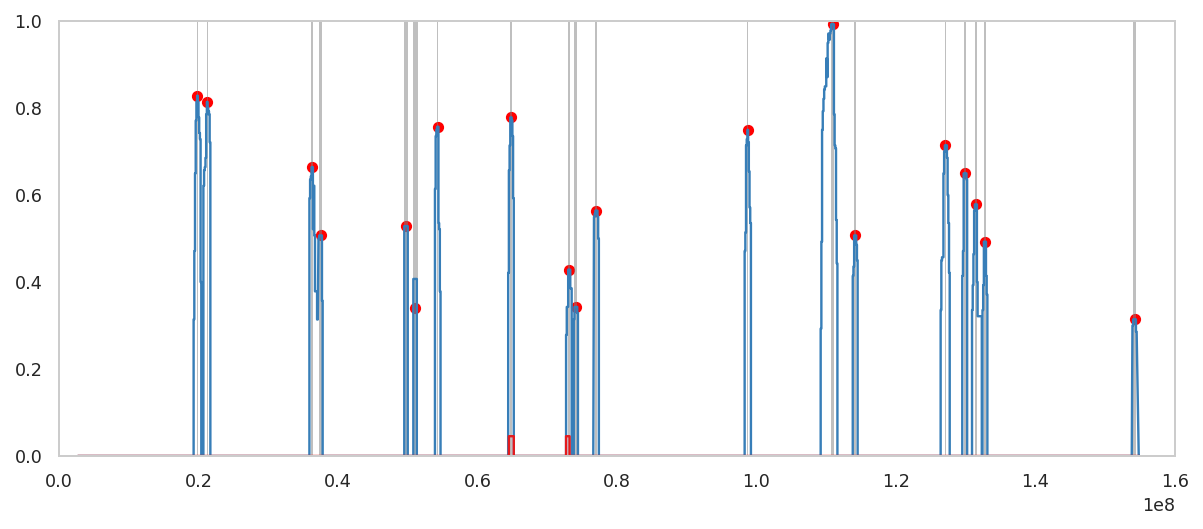

In [21]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y)
        g = ax.scatter(sweep_peaks.pos, sweep_peaks.prop_swept, c='red')

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y)

        for tup in sweep_peaks.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='gray',
                         linewidth=0,
                         alpha=0.5,
                         zorder=1))
        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        plt.savefig(str(figures_dir / 'tot_swept_peaks.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept_peaks.png'))
        

#mpld3.display(fig)

In [22]:
sweep_peaks.to_hdf(results_dir / 'sweep_peaks.hdf', 'df', format='table', mode='w')
sweep_peaks.to_csv(results_dir / 'sweep_peaks.csv')

## Sizes and numbers of clades in each window (including Africans)

In [23]:
def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Each swept individual may be part of a different clade. All we require is that such a clade spans at least some number of individuals. Get the  number of different clade sizes in each window:

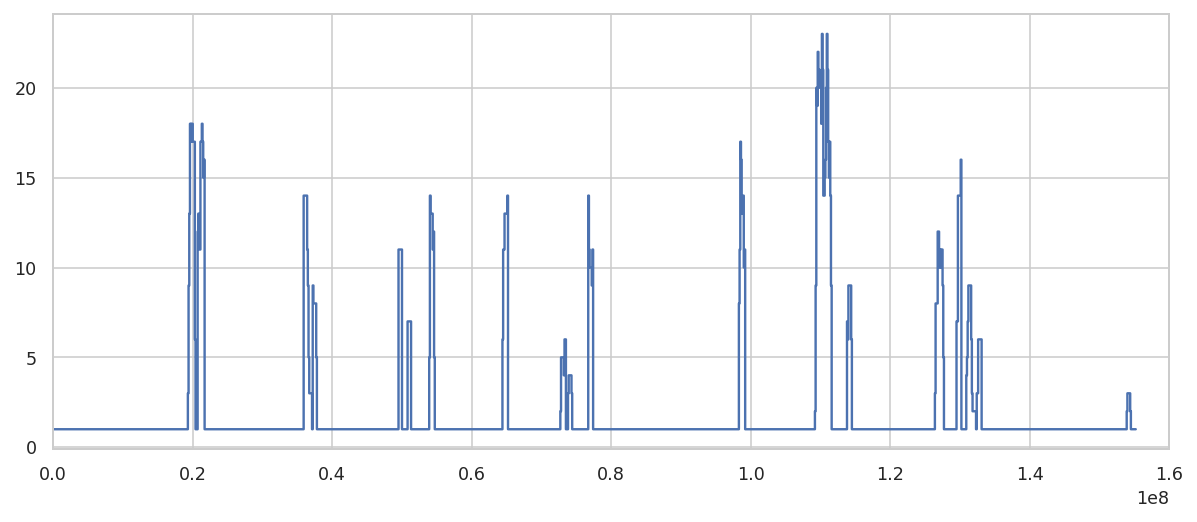

In [24]:
plt.figure(figsize=(10, 4))
plt.xlim(0,160e6)

nr_clade_sizes = sweep_data.groupby(['start', 'end']).clade_size.agg(lambda sr: sr.unique().size).reset_index()
nr_clade_sizes.loc[nr_clade_sizes.clade_size.isnull(), 'clade_size'] = 0
plot_df = stairs(nr_clade_sizes)
plt.plot(plot_df.pos, plot_df.clade_size) ;


Largest and smallest clade in each window:

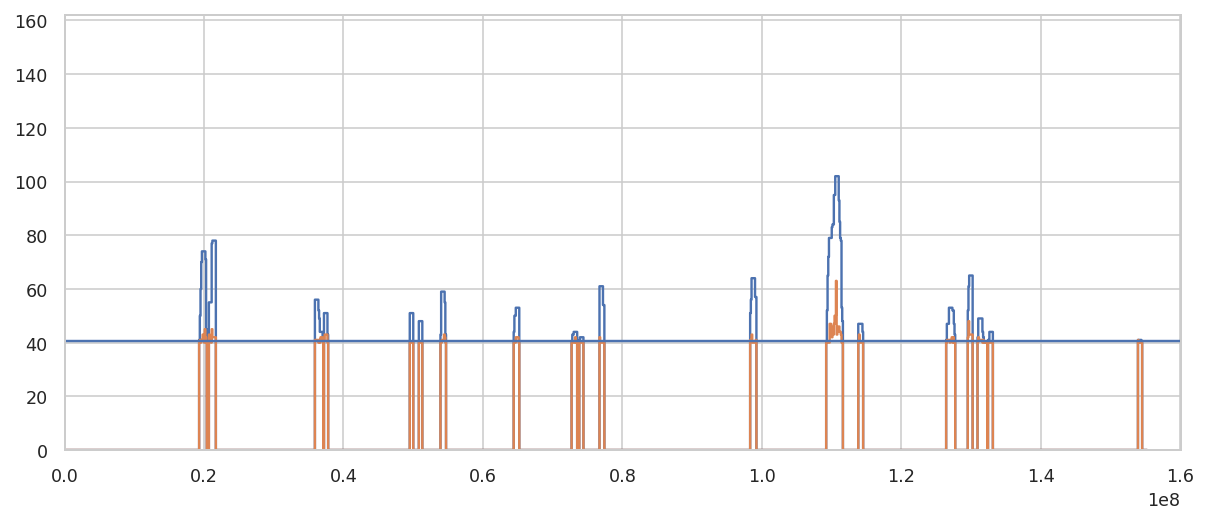

In [25]:
plt.figure(figsize=(10, 4))
plt.ylim(0,162)
plt.xlim(0,160e6)

max_clade_sizes = sweep_data.groupby(['start', 'end']).clade_size.max().reset_index()
max_clade_sizes.loc[max_clade_sizes.clade_size.isnull(), 'clade_size'] = 0
plot_df = stairs(max_clade_sizes)
plt.plot(plot_df.pos, plot_df.clade_size)

min_clade_sizes = sweep_data.groupby(['start', 'end']).clade_size.min().reset_index()
min_clade_sizes.loc[min_clade_sizes.clade_size.isnull(), 'clade_size'] = 0
plot_df = stairs(min_clade_sizes)
plt.plot(plot_df.pos, plot_df.clade_size) 

plt.axhline(162 * 0.25) ;

It seems the clade each sequence is part of is generally not much larger than the cutoff.

## Plot for paper:

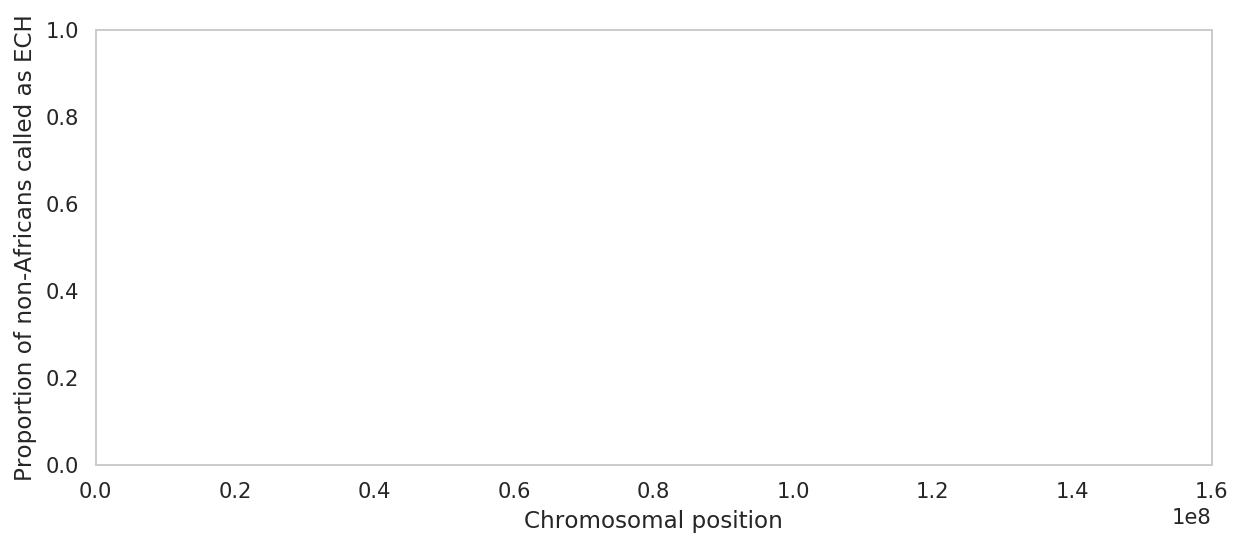

In [26]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.savefig(str(figures_dir / 'tot_swept_blank.pdf')) 

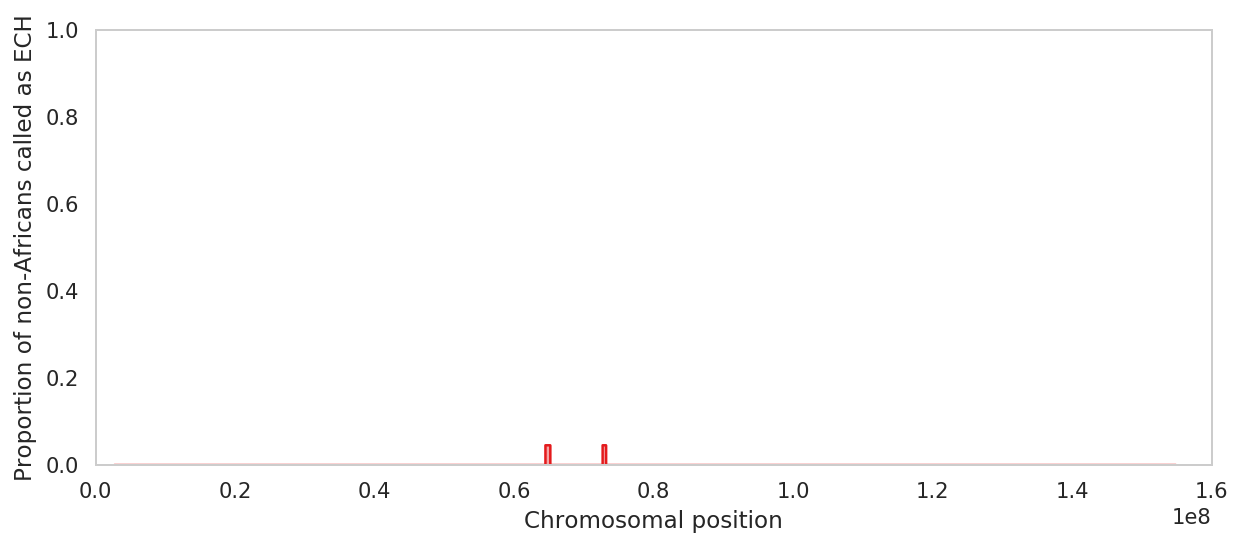

In [27]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['red'], zorder=2)
        ax.fill_between(x, 0, y, color=set1['red'], alpha=0.4, zorder=2)

        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.savefig(str(figures_dir / 'tot_swept_afr_only.pdf')) 

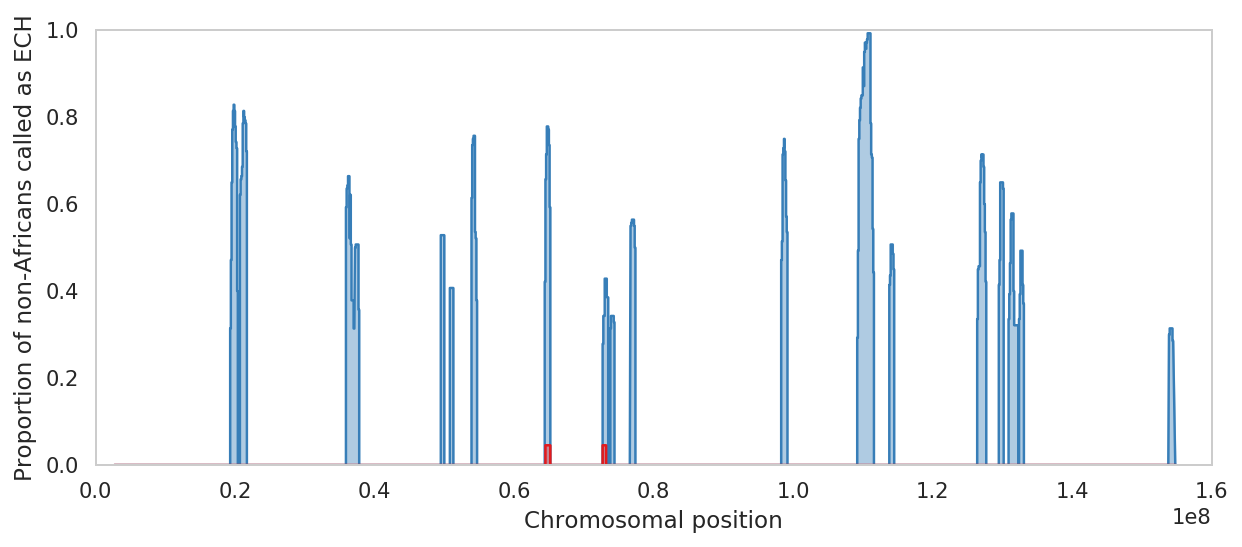

In [28]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['red'], zorder=2)
        ax.fill_between(x, 0, y, color=set1['red'], alpha=0.4, zorder=2)

        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.savefig(str(figures_dir / 'tot_swept.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept.png'))

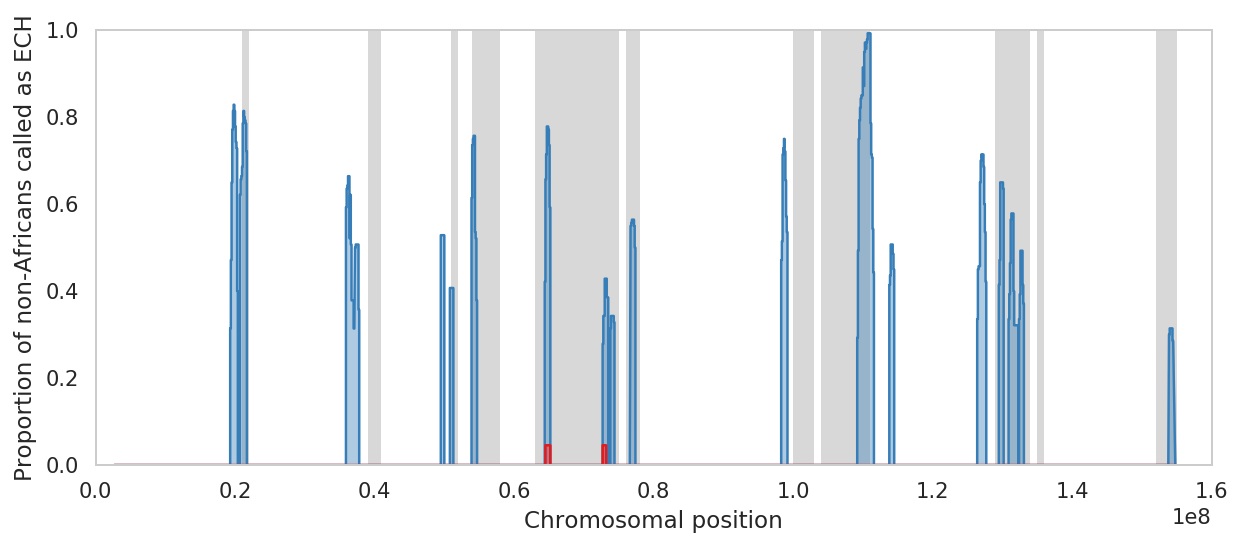

In [29]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

#with sns.color_palette([set1['blue'], set1['red']]):
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['red'], zorder=2)
        ax.fill_between(x, 0, y, color=set1['red'], alpha=0.4, zorder=2)

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='gray',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.savefig(str(figures_dir / 'tot_swept_ils.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept_ils.png'))

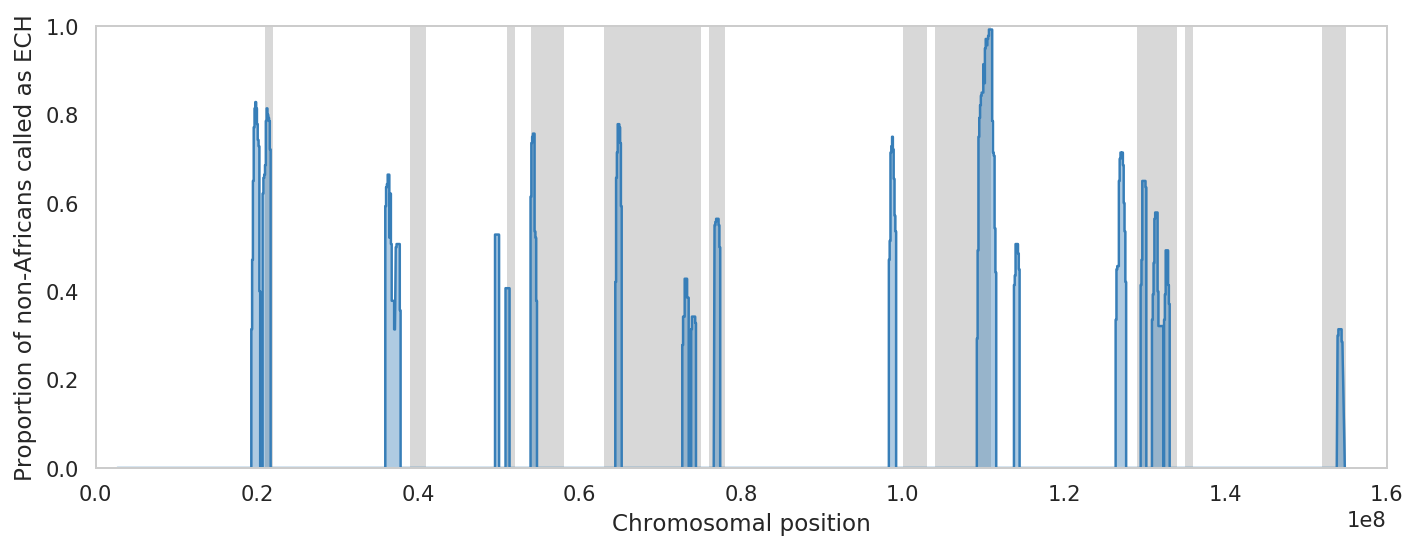

In [30]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='gray',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'tot_swept_ils_only_nonafr.pdf')) 

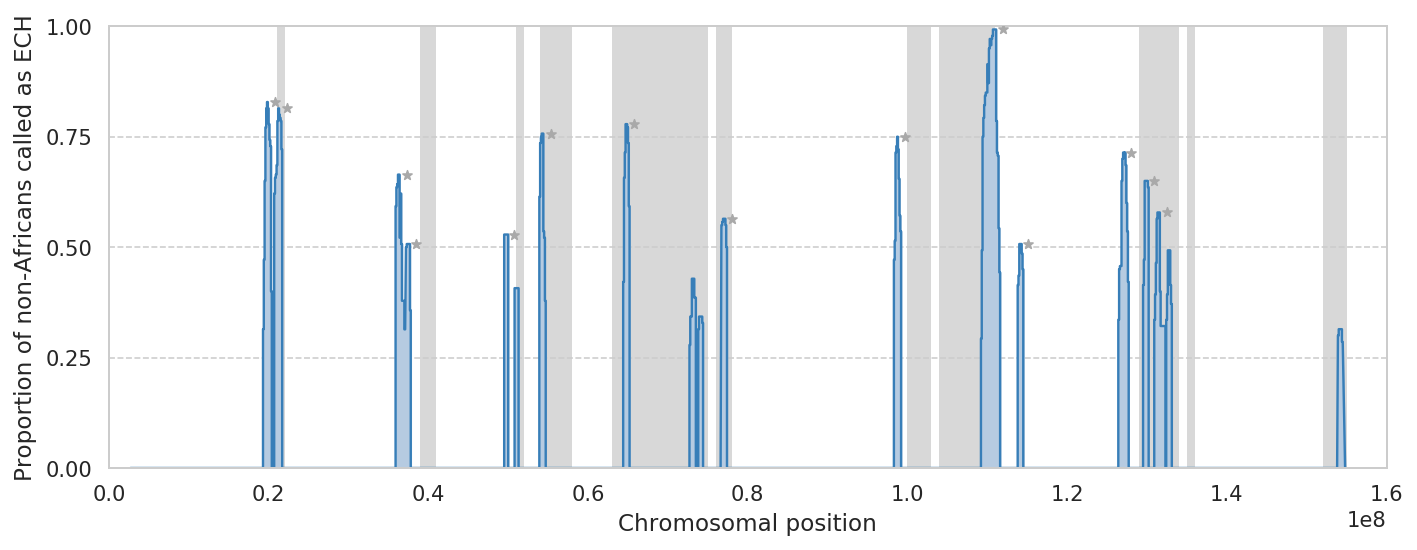

In [31]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

import matplotlib.ticker as ticker

with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid"):#, {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
#         ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)
        ax.fill_between(x, 0, y, color='#b6cbe1', zorder=1)

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                        linewidth=0,
                        facecolor='#d8d8d8',
                        #facecolor='gray',
                        #alpha=0.3,
                        zorder=0))
        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.scatter(sweep_peaks.loc[sweep_peaks.prop_swept>=0.5].pos + 1000000, 
                   sweep_peaks.loc[sweep_peaks.prop_swept>=0.5].prop_swept,
                   c='darkgray', marker='*', zorder=5)

        
        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
        ax.yaxis.grid(linestyle='--')
        ax.xaxis.grid(False)
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'tot_swept_ils_only_nonafr_alternative.pdf')) 

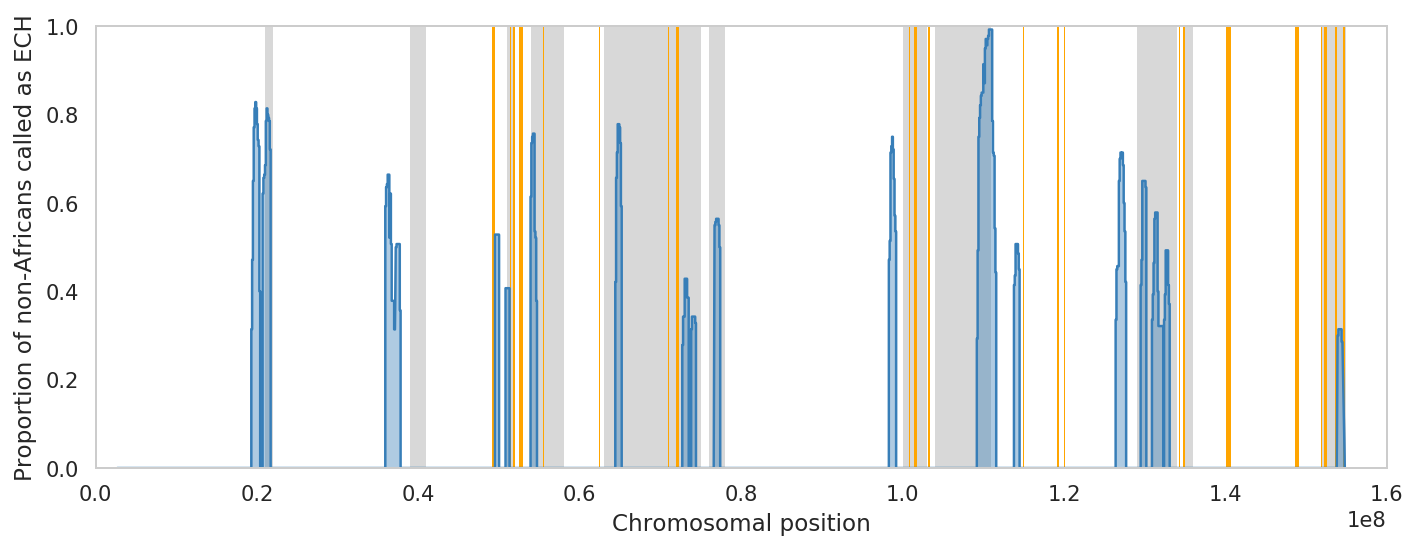

In [32]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')

with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='gray',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
            
        for tup in ampliconic_regions.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='orange',
                         linewidth=0,
                         alpha=1,
                         zorder=0))
            
        ax.set_ylim(0,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'tot_swept_ils_ampl.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept_ils_ampl.png'))

## Relative TMRCA_half

In [33]:
tmrca_stats_world = pandas.read_hdf(results_dir / 'pruned_tmrca_stats.hdf')#.loc[lambda df: df.region=='World']
tmrca_stats_world.head()

,start,end,chain,MCMC_sample,coal_half,tmrca,tmrca_half,rel_tmrca_half
0,0,100000,1.5,2750.0,226.957517,45083.337393,12645.212660,0.281658
1,100000,200000,1.5,2750.0,362.848331,47935.198573,14351.381341,0.300756
2,200000,300000,1.5,2750.0,551.114128,53009.238578,19172.584913,0.363367
3,300000,400000,1.5,2750.0,495.469935,50038.851797,14837.471573,0.297887
4,400000,500000,1.5,2750.0,513.143674,50557.752598,18956.576133,0.376540


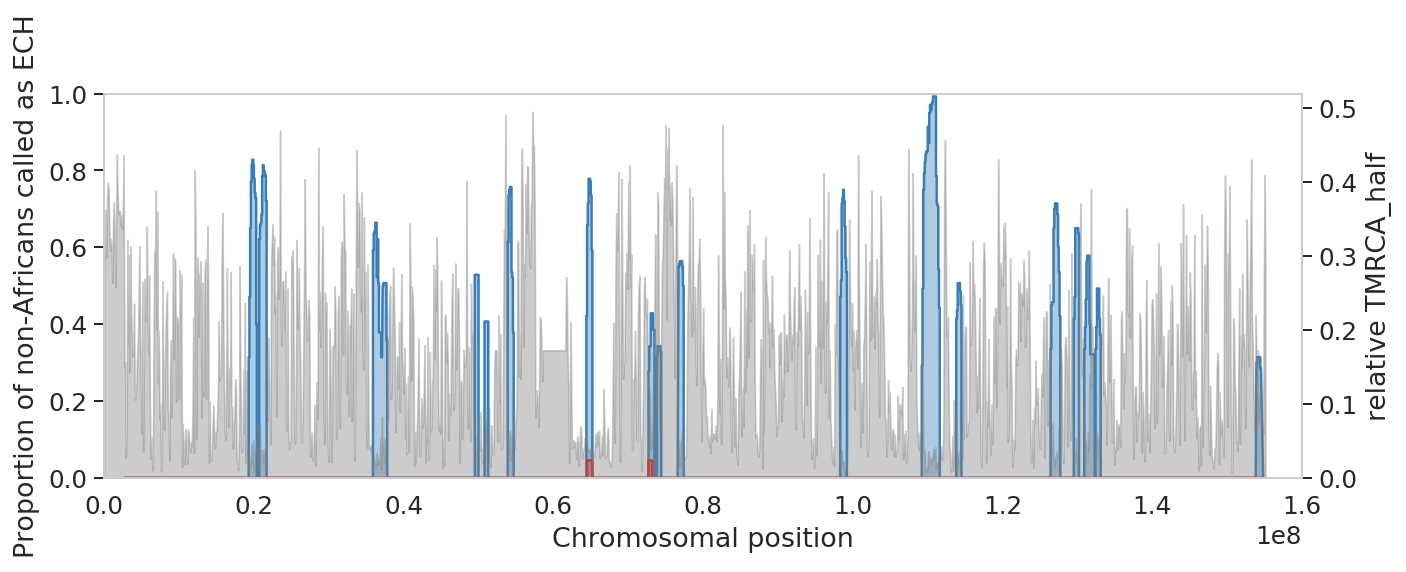

In [34]:
with sns.plotting_context('paper', font_scale=1.4):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['red'], zorder=2)
        ax.fill_between(x, 0, y, color=set1['red'], alpha=0.4, zorder=2)

        extra_ax = ax.twinx()
        extra_ax.fill_between(tmrca_stats_world.start, tmrca_stats_world.rel_tmrca_half, color='grey', alpha=0.4, zorder=0)
        extra_ax.grid(False)        

        ax.set_ylim(0,1)
        extra_ax.set_ylim(0)

        ax.set_xlim(0,160e6)
        
        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        extra_ax.set_ylabel('relative TMRCA_half')
        plt.tight_layout()
                
        plt.savefig(str(figures_dir / 'tot_swept_rel_tmrca_half.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept_rel_tmrca_half.png'))
        
#mpld3.display(fig)

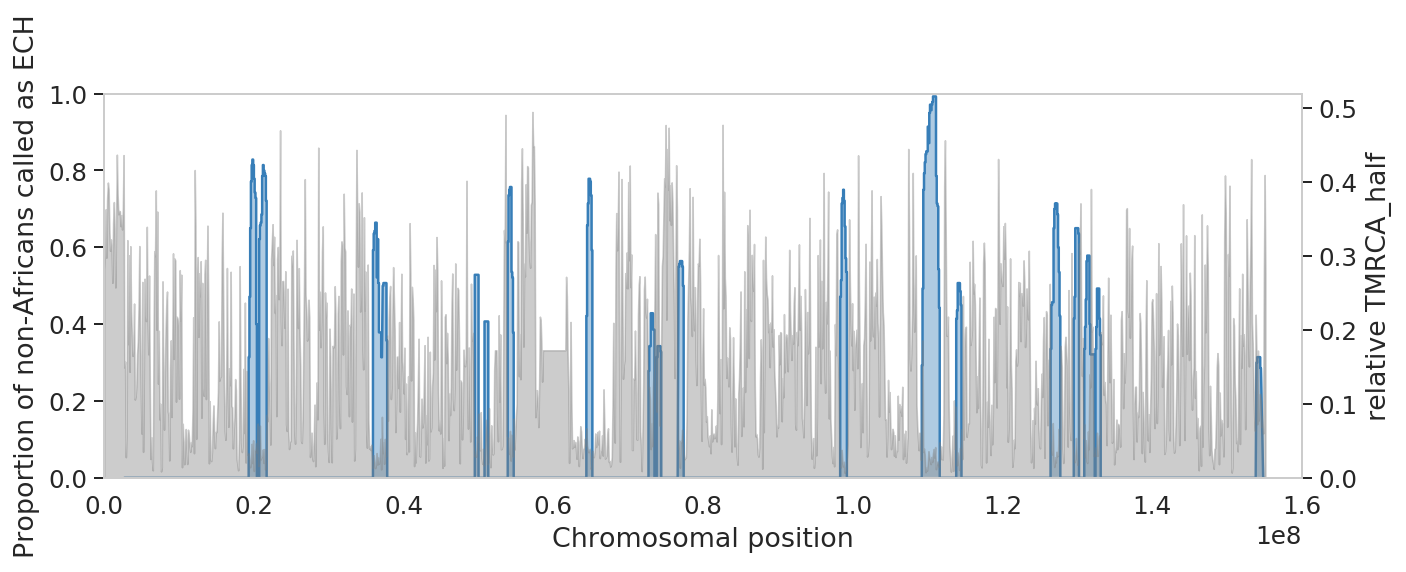

In [35]:
with sns.plotting_context('paper', font_scale=1.4):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        extra_ax = ax.twinx()
        extra_ax.fill_between(tmrca_stats_world.start, tmrca_stats_world.rel_tmrca_half, color='grey', alpha=0.4, zorder=0)
        extra_ax.grid(False)        

        ax.set_ylim(0,1)
        extra_ax.set_ylim(0)

        ax.set_xlim(0,160e6)
        
        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        extra_ax.set_ylabel('relative TMRCA_half')
        plt.tight_layout()
                
        plt.savefig(str(figures_dir / 'tot_swept_rel_tmrca_half_only_nonafr.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept_rel_tmrca_half_only_nonafr.png'))
        
#mpld3.display(fig)

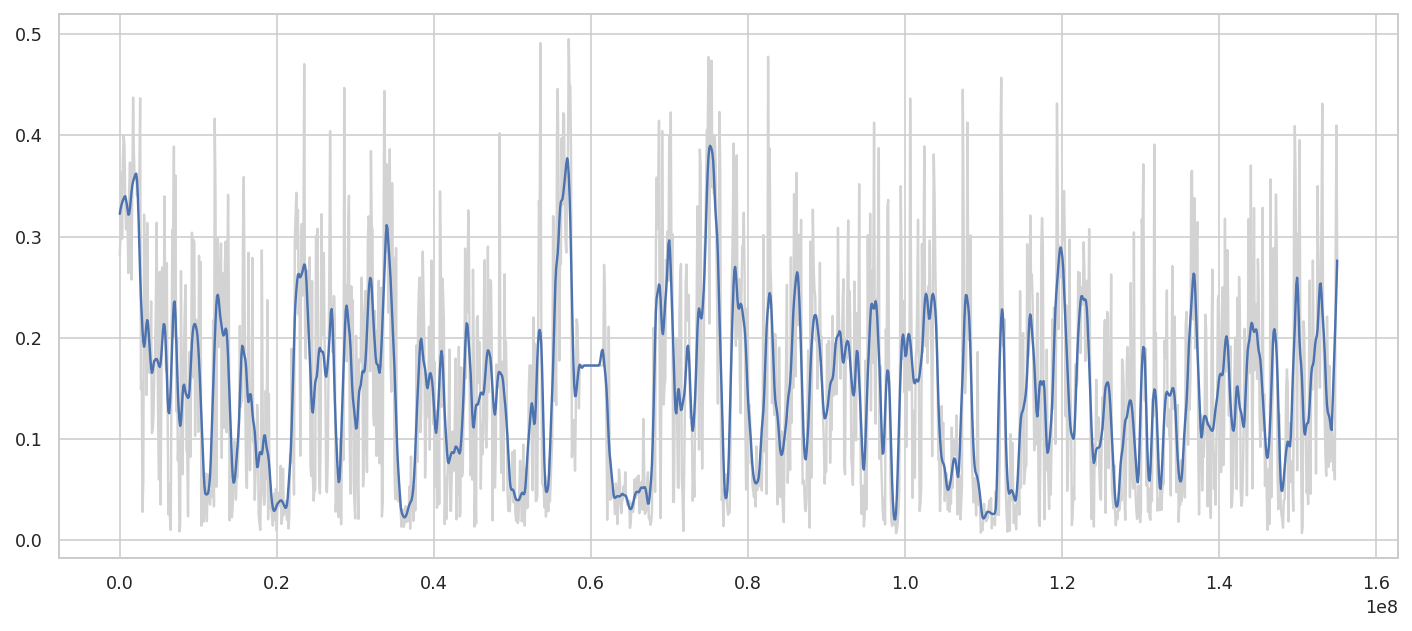

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tmrca_stats_world.start, tmrca_stats_world.rel_tmrca_half, c='lightgrey')
filtered = lowess(tmrca_stats_world.rel_tmrca_half, tmrca_stats_world.start, 
                  is_sorted=True, frac=0.01, it=0)
g = ax.plot(filtered[:,0], filtered[:,1])

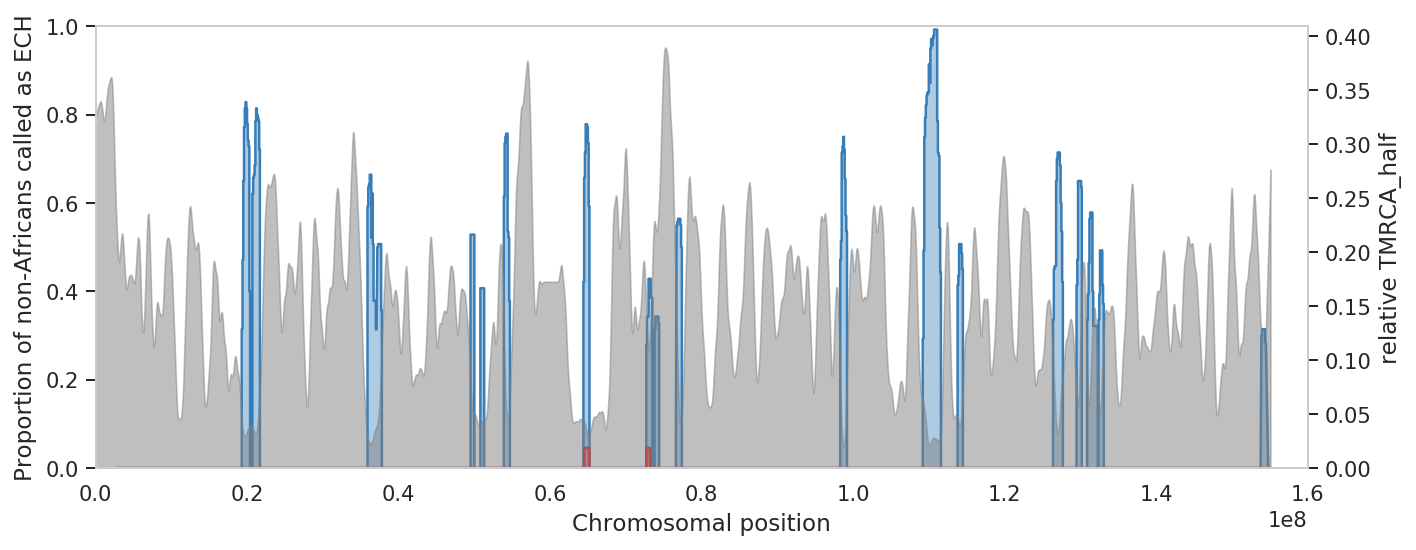

In [37]:
with sns.plotting_context('paper', font_scale=1.2):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['red'], zorder=2)
        ax.fill_between(x, 0, y, color=set1['red'], alpha=0.4, zorder=2)

        extra_ax = ax.twinx()
        extra_ax.fill_between(filtered[:,0], 0, filtered[:,1], color='grey', alpha=0.5, zorder=0)
        extra_ax.grid(False)
        
        ax.set_ylim(0,1)
        extra_ax.set_ylim(0)
        
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        extra_ax.set_ylabel('relative TMRCA_half')
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'tot_swept_smoothed_rel_tmrca_half.pdf')) 
        plt.savefig(str(figures_dir / 'tot_swept_smoothed_rel_tmrca_half.png'))

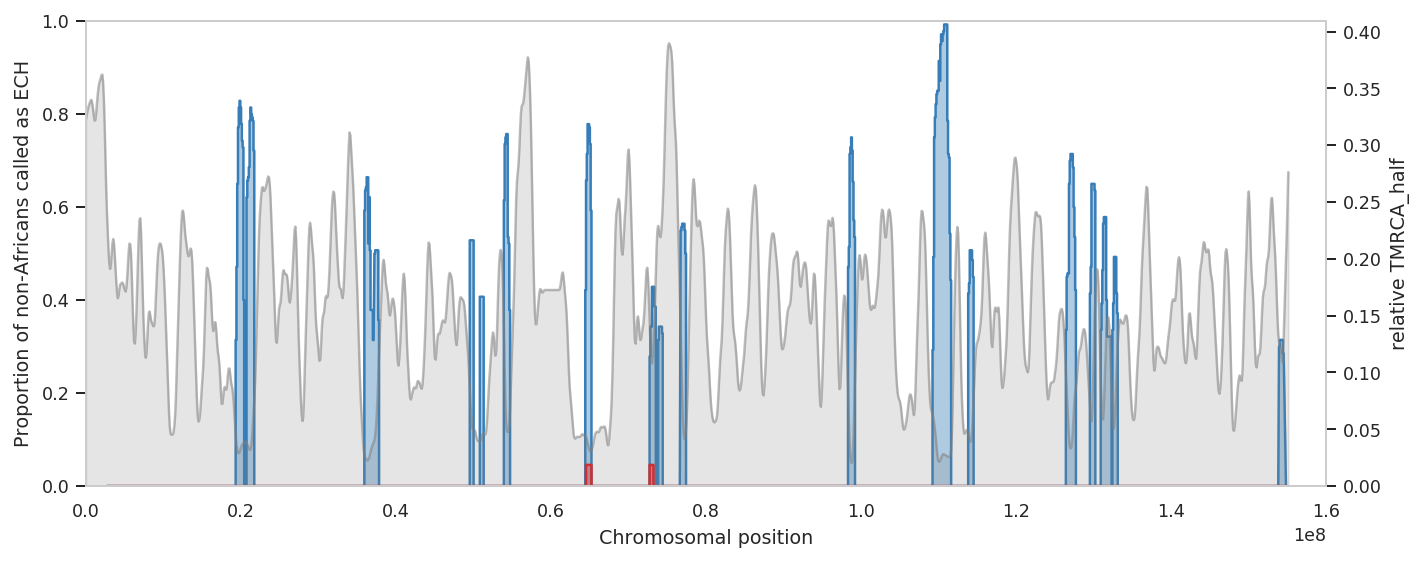

In [38]:
with sns.plotting_context('paper', font_scale=1.0):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        x = [j for i in zip(afr_total_swept.start, afr_total_swept.end) for j in i]
        y = [j for i in zip(afr_total_swept.prop_swept, afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['red'], zorder=2)
        ax.fill_between(x, 0, y, color=set1['red'], alpha=0.4, zorder=2)

        extra_ax = ax.twinx()
        extra_ax.plot(filtered[:,0], filtered[:,1], c='grey', alpha=0.5, zorder=0)
        extra_ax.fill_between(filtered[:,0], 0, filtered[:,1], color='grey', alpha=0.2, zorder=0)
        extra_ax.grid(False)
        
        ax.set_ylim(0,1)
        extra_ax.set_ylim(0)
        
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        extra_ax.set_ylabel('relative TMRCA_half')
        plt.tight_layout()